/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


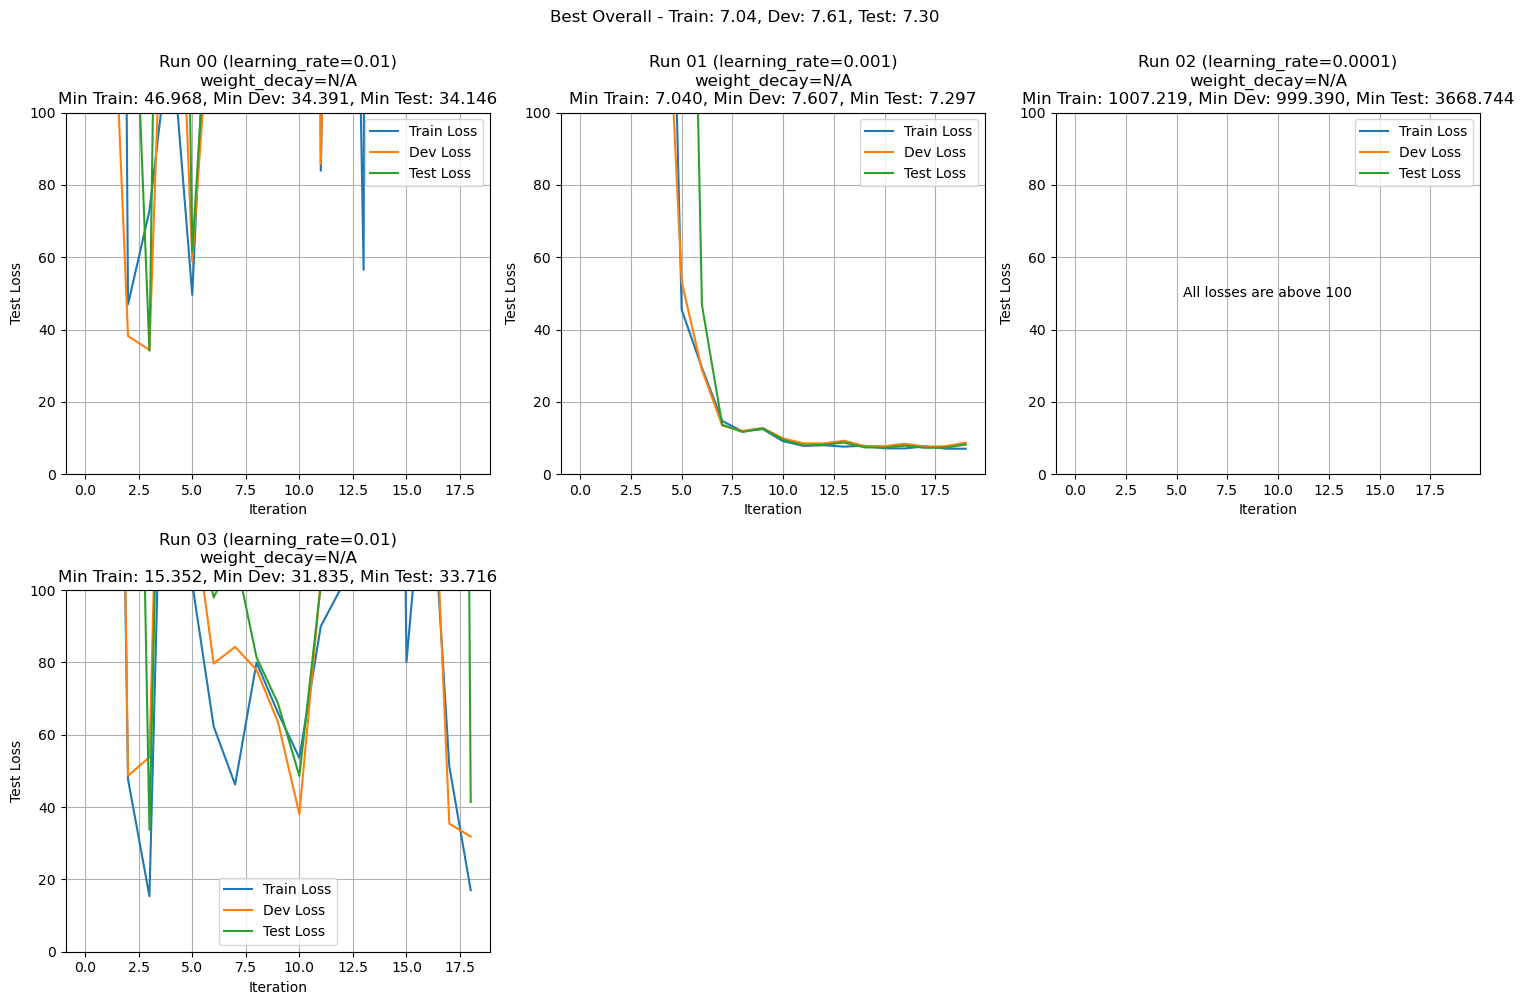

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_losses_from_csv(csv_path, ax, run_index, learning_rate, additional_params, y_lim=None):
    # Read CSV file
    df = pd.read_csv(csv_path)
    
    # Filter out NaN and Inf values
    losses = np.concatenate([df['train_loss'], df['dev_loss'], df['test_loss']])
    losses = losses[np.isfinite(losses)]  # Filter out NaN and Inf values
    
    if len(losses) > 0:  # Only calculate limits if we have valid values
        # Calculate min losses
        min_train = df['train_loss'].min()
        min_dev = df['dev_loss'].min()
        min_test = df['test_loss'].min()
        
        # Plot losses
        ax.plot(df['train_loss'], label='Train Loss')
        ax.plot(df['dev_loss'], label='Dev Loss')
        ax.plot(df['test_loss'], label='Test Loss')
        
        # Check for NaN values and shade regions
        for loss_type, color in [('train_loss', 'blue'), ('dev_loss', 'red'), ('test_loss', 'green')]:
            nan_idx = df[loss_type].isna().idxmax() if df[loss_type].isna().any() else -1
            if nan_idx >= 0:
                ax.axvspan(nan_idx, len(df)-1, alpha=0.2, color=color, 
                          label=f'{loss_type.split("_")[0]} NaN at {nan_idx}')
        
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Test Loss')
        ax.legend()
        ax.set_ylim(0, y_lim if y_lim is not None else min_train * 4)
        ax.grid(True)
        
        # Check if none of the losses are within 0 to y_lim
        if y_lim is not None and all(min_loss > y_lim for min_loss in [min_train, min_dev, min_test]):
            ax.text(0.5, 0.5, f'All losses are above {y_lim}', 
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ax.transAxes)
        
        # Set title with run index, learning rate, additional params and min losses
        title = f'Run {run_index:02d} (learning_rate={learning_rate})\n'
        if additional_params:
            params_str = ', '.join([f'{k}={v}' for k,v in additional_params.items()])
            title += f'{params_str}\n'
        title += f'Min Train: {min_train:.3f}, Min Dev: {min_dev:.3f}, Min Test: {min_test:.3f}'
        ax.set_title(title)
        
        return min_train, min_dev, min_test
    else:
        ax.text(0.5, 0.5, 'No valid loss values', 
                horizontalalignment='center',
                verticalalignment='center',
                transform=ax.transAxes)
        return float('inf'), float('inf'), float('inf')

def plot_all_runs(base_path, additional_param_keys=None, condition_dict=None, y_lim=None):
    # Get all subdirectories and collect run info
    runs = []
    for d in os.listdir(base_path):
        if os.path.isdir(os.path.join(base_path, d)):
            # Extract run index from directory name
            part = d.split('_')[2]
            params_path = os.path.join(base_path, d, 'params.json')
            if os.path.exists(params_path):
                with open(params_path) as f:
                    params = json.load(f)
                    
                    # Check if run matches conditions
                    if condition_dict:
                        matches_conditions = all(
                            params.get(k) == v if not isinstance(v, list) else params.get(k) in v
                            for k, v in condition_dict.items()
                        )
                        if not matches_conditions:
                            continue
                            
                    learning_rate = params.get('learning_rate', 'N/A')
                    additional_params = {}
                    if additional_param_keys:
                        additional_params = {k: params.get(k, 'N/A') for k in additional_param_keys}
                    runs.append((int(part), d, learning_rate, additional_params))
    
    # Group runs by learning rate
    lr_groups = {}
    for run_idx, dir_name, lr, additional_params in runs:
        if lr not in lr_groups:
            lr_groups[lr] = []
        lr_groups[lr].append((run_idx, dir_name, additional_params))
    
    # Sort learning rates and runs within each group
    sorted_lrs = sorted(lr_groups.keys(), reverse=True)
    for lr in sorted_lrs:
        lr_groups[lr].sort()
    
    # Calculate grid dimensions
    n_cols = len(sorted_lrs)  # One column per learning rate
    n_rows = max(len(group) for group in lr_groups.values())
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    
    # Handle case where axes is 1D array
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Track best losses across all runs
    best_train = float('inf')
    best_dev = float('inf')
    best_test = float('inf')
    
    # Plot runs grouped by learning rate
    for col, lr in enumerate(sorted_lrs):
        for row, (run_idx, dir_name, additional_params) in enumerate(lr_groups[lr]):
            csv_path = os.path.join(base_path, dir_name, 'progress.csv')
            if os.path.exists(csv_path):
                min_train, min_dev, min_test = plot_losses_from_csv(csv_path, axes[row, col], run_idx, lr, additional_params, y_lim)
                best_train = min(best_train, min_train)
                best_dev = min(best_dev, min_dev)
                best_test = min(best_test, min_test)
    
    # Add overall best losses as a suptitle
    fig.suptitle(f'Best Overall - Train: {best_train:.2f}, Dev: {best_dev:.2f}, Test: {best_test:.2f}',
                 fontsize=12, y=1.0)
    # Remove empty subplots
    for row in range(n_rows):
        for col in range(n_cols):
            if row >= len(lr_groups[sorted_lrs[col]]):
                fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()

# Example usage:
folder_path = input("Enter the folder path: ")
plot_all_runs(folder_path, additional_param_keys=['weight_decay'], y_lim=100)
